First figure of the manuscript, showing 20-40 Hz exponent. 
- Brain maps of exponent across wake and sleep.
- Overall exponent changes across wake and sleep.
- Correlation sizes of exponent with T1w/T2w score.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from copy import deepcopy
import pandas as pd
import numpy as np
import pickle
from scipy.stats import zscore, bootstrap, ttest_rel
import matplotlib.pyplot as plt
import mne
import nibabel as nib

import mni_utils as uti
from mni_plots import (
    plot_parcellated_metric,
    half_violin_plot,
    plot_corr,
    slope_plot,
    fsize,
    save_figure,
    _get_figsize_inches,
    _get_fontsize_ratio,
    _set_font_params,
)

c:\Users\ricca\anaconda3\envs\neural_dynamics\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package yasa is out of date. Your version is 0.6.3, the latest is 0.6.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Set appropriate fonts for plotting:

In [3]:
_set_font_params()

Paths and names:

In [4]:
data_path = Path("F:\\iEEG_neural_dynamics\\MNIOpen")
tau_path = data_path.joinpath("Results_psd_exp")
fig_path = data_path.joinpath("Figures")

Parcellation:

In [5]:
subjects_dir = str(mne.datasets.sample.data_path()) + "/subjects"
parc_map_name = "HCPMMP1"
annot_file = annot_file = (
    subjects_dir + "/fsaverage/label/lh." + parc_map_name + ".annot"
)
labels_mne = mne.read_labels_from_annot(
    "fsaverage", parc_map_name, "lh", subjects_dir=subjects_dir
)
parc_labels, ctab, parc_names = nib.freesurfer.read_annot(annot_file)

Reading labels from parcellation...
   read 181 labels from C:\Users\ricca\mne_data\MNE-sample-data\subjects\fsaverage\label\lh.HCPMMP1.annot


### A) Plot of parcellated brain areas

In [27]:
df_plot = {
    stage: pd.read_csv(tau_path.joinpath(f"exp_parc_{stage}.csv"), index_col=0)
    for stage in ["W", "N3", "R"]
}
# Differences
df_plot_W_N3 = df_plot["N3"] - df_plot["W"]
df_plot_W_R = df_plot["R"] - df_plot["W"]

In [28]:
minmax_stages = {"W": (2, 4), "N3": (2, 3), "R": (1.5, 3.5)}
title_dict = {"W": "Wake", "N3": "NREM3", "R": "REM"}

# Loop through stages
for stage in ["W", "N3", "R"]:

    fig, ax = plot_parcellated_metric(
        df_plot[stage].to_numpy().squeeze(),
        parc_labels,
        subjects_dir,
        labels_mne,
        log_scale=False,
        minmax=minmax_stages[stage],
        title=title_dict[stage],
        cmap="viridis",
        label="Exponent [a.u.]",
        cbar_format="1f"
    )
    # plt.show()

    fig.savefig(fig_path.joinpath("Fig_xx", f"FigX_exp_parc_{stage}.svg"), format="svg")
    plt.close(fig)

### B) Maps of differences

In [29]:
# NREM3 figure
fig, ax = plot_parcellated_metric(
    df_plot_W_N3.to_numpy().squeeze(),
    parc_labels,
    subjects_dir,
    labels_mne,
    log_scale=False,
    minmax=(0.5, 1.8),
    zero_center=True,
    title="NREM3 - Wake",
    cmap="bwr",
    label="Exponent difference [a.u.]",
    cbar_format="1f",
)
fig.savefig(fig_path.joinpath("Fig_xx", f"FigX_exp_parc_N3-W.svg"), format="svg")
plt.close(fig)

# REM figure
fig, ax = plot_parcellated_metric(
    df_plot_W_R.to_numpy().squeeze(),
    parc_labels,
    subjects_dir,
    labels_mne,
    log_scale=False,
    minmax=(0.5, 1.5),
    zero_center=True,
    title="REM - Wake",
    cmap="bwr",
    label="Exponent difference [a.u.]",
    cbar_format="1f",
)
fig.savefig(fig_path.joinpath("Fig_xx", f"FigX_exp_parc_R-W.svg"), format="svg")
plt.close(fig)

### C) Average increase of tau during sleep

In [32]:
# Add stage to the dataframe
df_metric = deepcopy(df_plot)
df_metric["W"]["stage"] = "W"
df_metric["N3"]["stage"] = "N3"
df_metric["R"]["stage"] = "R"
df_metric = pd.concat(df_metric.values())
df_metric.rename(columns={"0": "tau"}, inplace=True)
df_metric = df_metric.pivot(columns="stage", values="tau")
df_metric["ID"] = np.arange(len(df_metric.index))

diff W - N3 : -0.6018311581697555 6.041243835837795e-52
diff W - R : -0.4144329571806337 7.210177448739171e-31


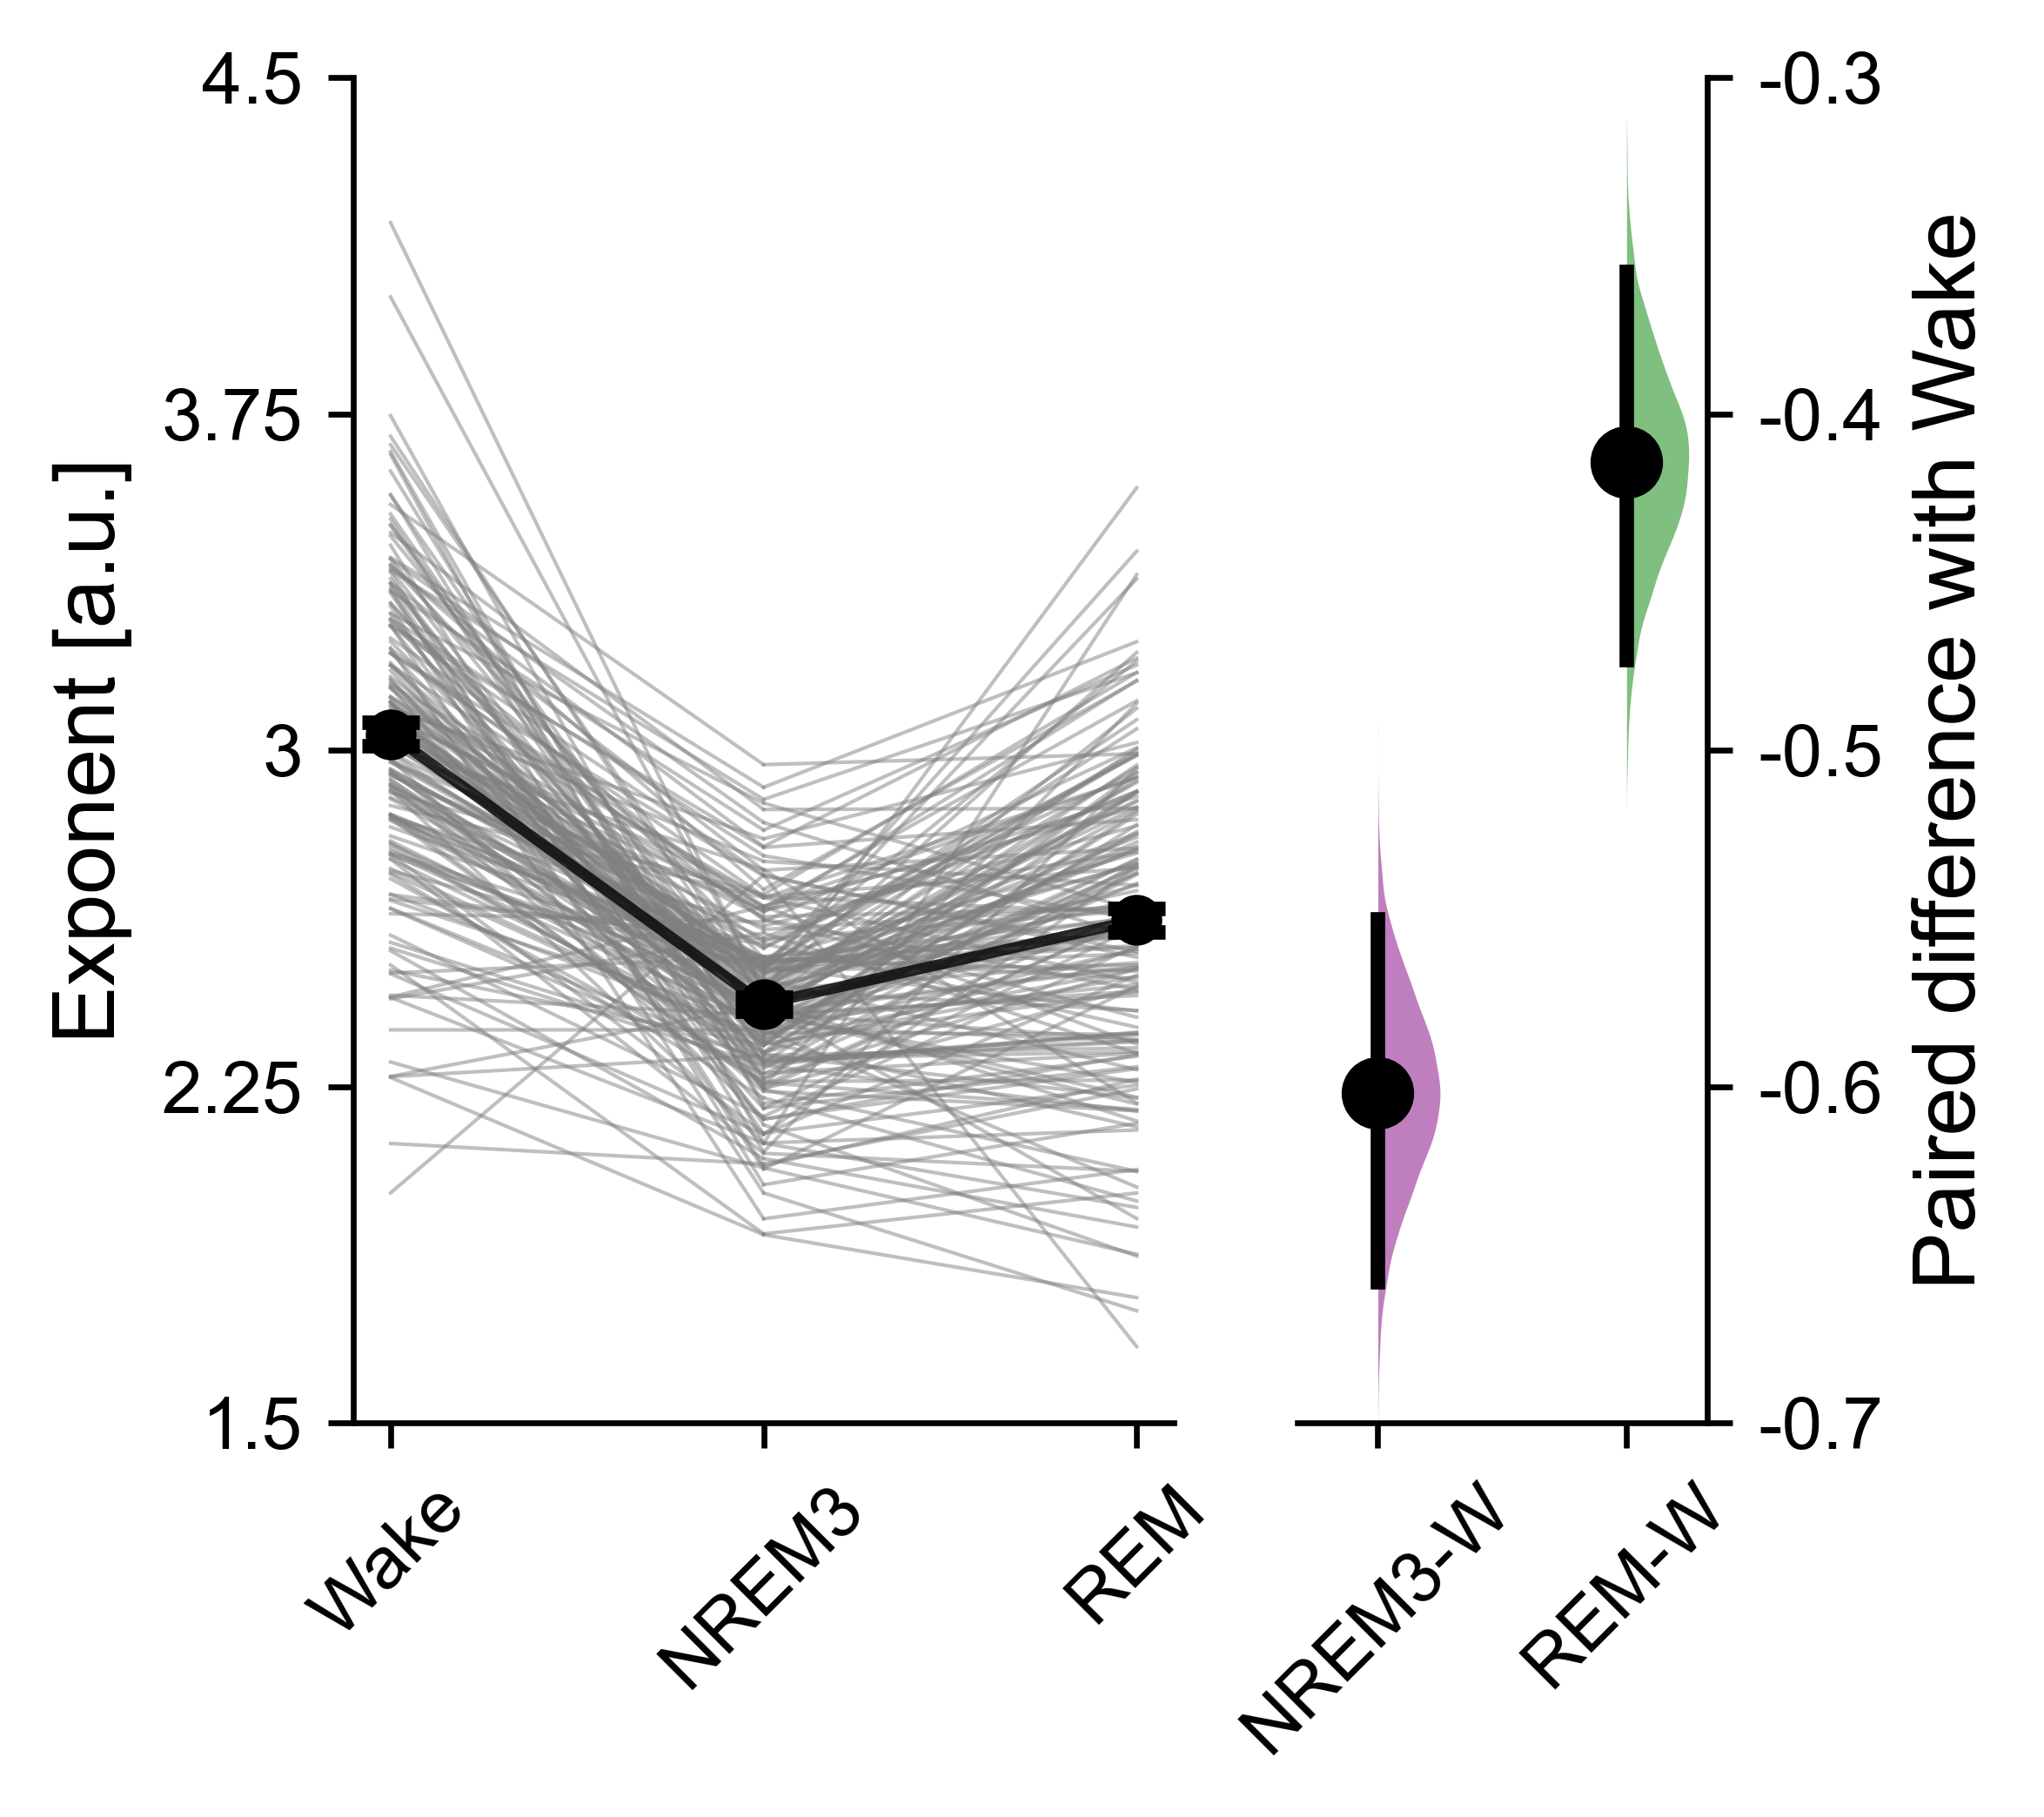

In [24]:
# Define colors for stages
stage_colors = {"W": "red", "N3": "purple", "R": "green"}

# Figure
fig, axs = plt.subplots(
    1, 2, figsize=_get_figsize_inches((8.5, 8.5)), width_ratios=[2, 1], dpi=600,
)

# Slope plot
df_metric_plot = df_metric[["W", "N3", "R"]].copy()
axs[0] = slope_plot(axs[0], df_metric_plot)
# Plot parameters
axs[0].set_ylabel("Exponent [a.u.]", fontsize=fsize.LABEL_SIZE)
axs[0].set_ylim(1.5, 4.5)
axs[0].set_yticks([1.5, 2.25, 3, 3.75, 4.5], labels=[1.5, 2.25, 3, 3.75, 4.5], fontsize=fsize.TICK_SIZE)
axs[0].set_xticks(
    [0, 1, 2],
    ["Wake", "NREM3", "REM"],
    rotation=45,
    ha="center",
    fontsize=fsize.TICK_SIZE,
)


# Add contrasts
def avg_diff(x, y):
    return np.mean(x - y)
# Plot differences
for i, stage in enumerate(["N3", "R"]):
    avg = avg_diff(df_metric_plot[stage], df_metric_plot["W"])
    pval = ttest_rel(df_metric_plot[stage], df_metric_plot["W"])[1]
    p_str = f"p = {pval:.2f}" if pval >= 0.001 else "p < 0.001"
    p_str += "*" if pval < 0.05 else ""
    print("diff W -", stage, ":", avg, pval)
    res_boot = bootstrap(
        (df_metric_plot[stage], df_metric_plot["W"]),
        avg_diff,
        paired=True,
        random_state=290496,
    )
    axs[1] = half_violin_plot(
        axs[1],
        avg,
        x_pos=i,
        ci=list(res_boot.confidence_interval),
        y_boot=res_boot.bootstrap_distribution,
        color=stage_colors[stage],
        pval=None,
    )
# Plot parameters
axs[1].set_ylabel("Paired difference with Wake", fontsize=fsize.LABEL_SIZE)
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()
axs[1].set_ylim(-0.7, -0.3)
axs[1].set_yticks(
    [-0.7, -0.6,-0.5,-0.4,-0.3],
    labels=[-0.7, -0.6,-0.5,-0.4,-0.3],
    fontsize=fsize.TICK_SIZE,
)
axs[1].set_xticks(
    [0, 1], ["NREM3-W", "REM-W"], rotation=45, fontsize=fsize.TICK_SIZE
)
axs[1].spines[["top", "left"]].set_visible(False)

# Save figure
save_figure(fig, fig_path.joinpath("Fig_xx", f"FigX_exp_change_stages.svg"))
plt.show()

### D) Correlation with structure

Load T1w/T2w data and the centroids coordinates of the parcellation:

In [30]:
df_struct = pd.read_csv(data_path.joinpath("df_structural_avg.csv"), index_col=0)
map_coords = pd.read_csv(data_path.joinpath("mmp_centroids_coords.csv"), index_col=0)

Generating 1000 permutations...
Generating 1000 permutations...
Generating 1000 permutations...


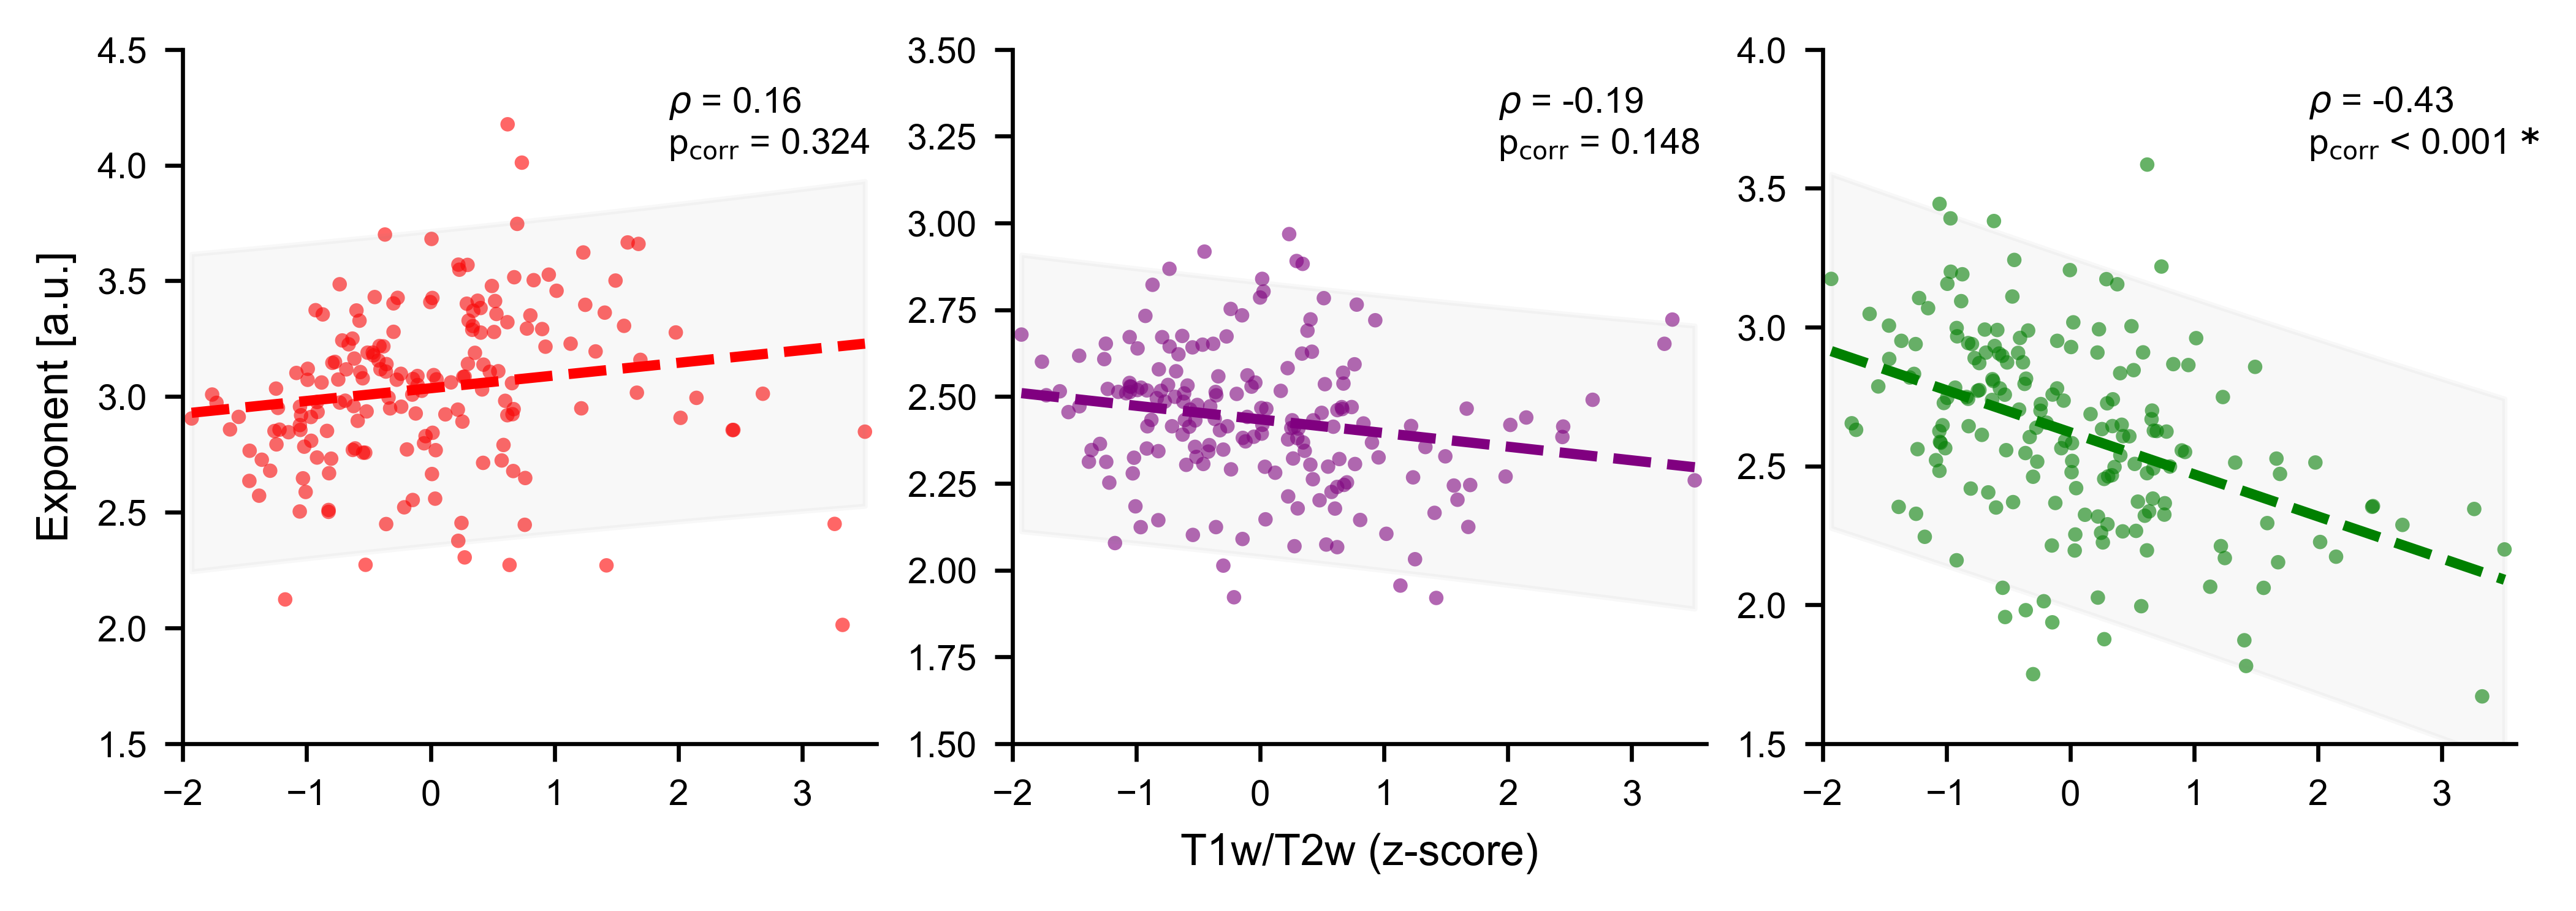

In [31]:
title_dict = {"W": "Wake", "N3": "NREM3", "R": "REM"}
color_stages = {"W": "red", "N3": "purple", "R": "green"}
xlims_stages = {"W": (-2, 3.6), "N3": (-2, 3.6), "R": (-2, 3.6)}
ylims_stages = {"W": (1.5, 4.5), "N3": (1.5, 3.5), "R": (1.5, 4)}

fig, axs = plt.subplots(1, 3, figsize=_get_figsize_inches((17.5, 6)), dpi=600, layout="constrained")

rhos, p_corrs, rhos_boot = {}, {}, {}

for i, stage in enumerate(["W", "N3", "R"]):
    # Import dataframe
    df_metric = df_plot[stage].copy()

    # Get data
    x = zscore(df_struct["T1T2"], ddof=1).to_numpy()
    y = df_metric.loc[df_struct.index].to_numpy().squeeze()

    # Get correlation values
    rho, p_corr = uti.get_pcorr(x, y, map_coords, method="vasa", corr_type="pearson")
    rho_boot = uti.get_rho_boot(x, y, corr_type="pearson")
    rhos[stage] = rho
    p_corrs[stage] = p_corr
    rhos_boot[stage] = rho_boot

    # Plot
    axs[i] = plot_corr(
        axs[i],
        x,
        y,
        rho,
        p_corr,
        markersize=8,
        color=color_stages[stage],
        # title=title_dict[stage],
        xlabel="T1w/T2w (z-score)", #"Anatomical Hierarchy Score",
        ylabel="Exponent [a.u.]",
        xlims=xlims_stages[stage],
        ylims=ylims_stages[stage],
    )
    if i > 0:
        axs[i].set_ylabel("", fontsize=0)
    if i != 1:
        axs[i].set_xlabel("", fontsize=0)

    # axs[i].set_xticks(
    #     [-1, 2.6], labels=["association", "sensory"], 
    #     fontsize=fsize.LABEL_SIZE * _get_fontsize_ratio((6, 6))
    # )

# Save figure
save_figure(fig, fig_path.joinpath("Fig_xx", f"FigX_tau_corr_struct.svg"))

plt.show()

### E) Average PSDs across wake and sleep 

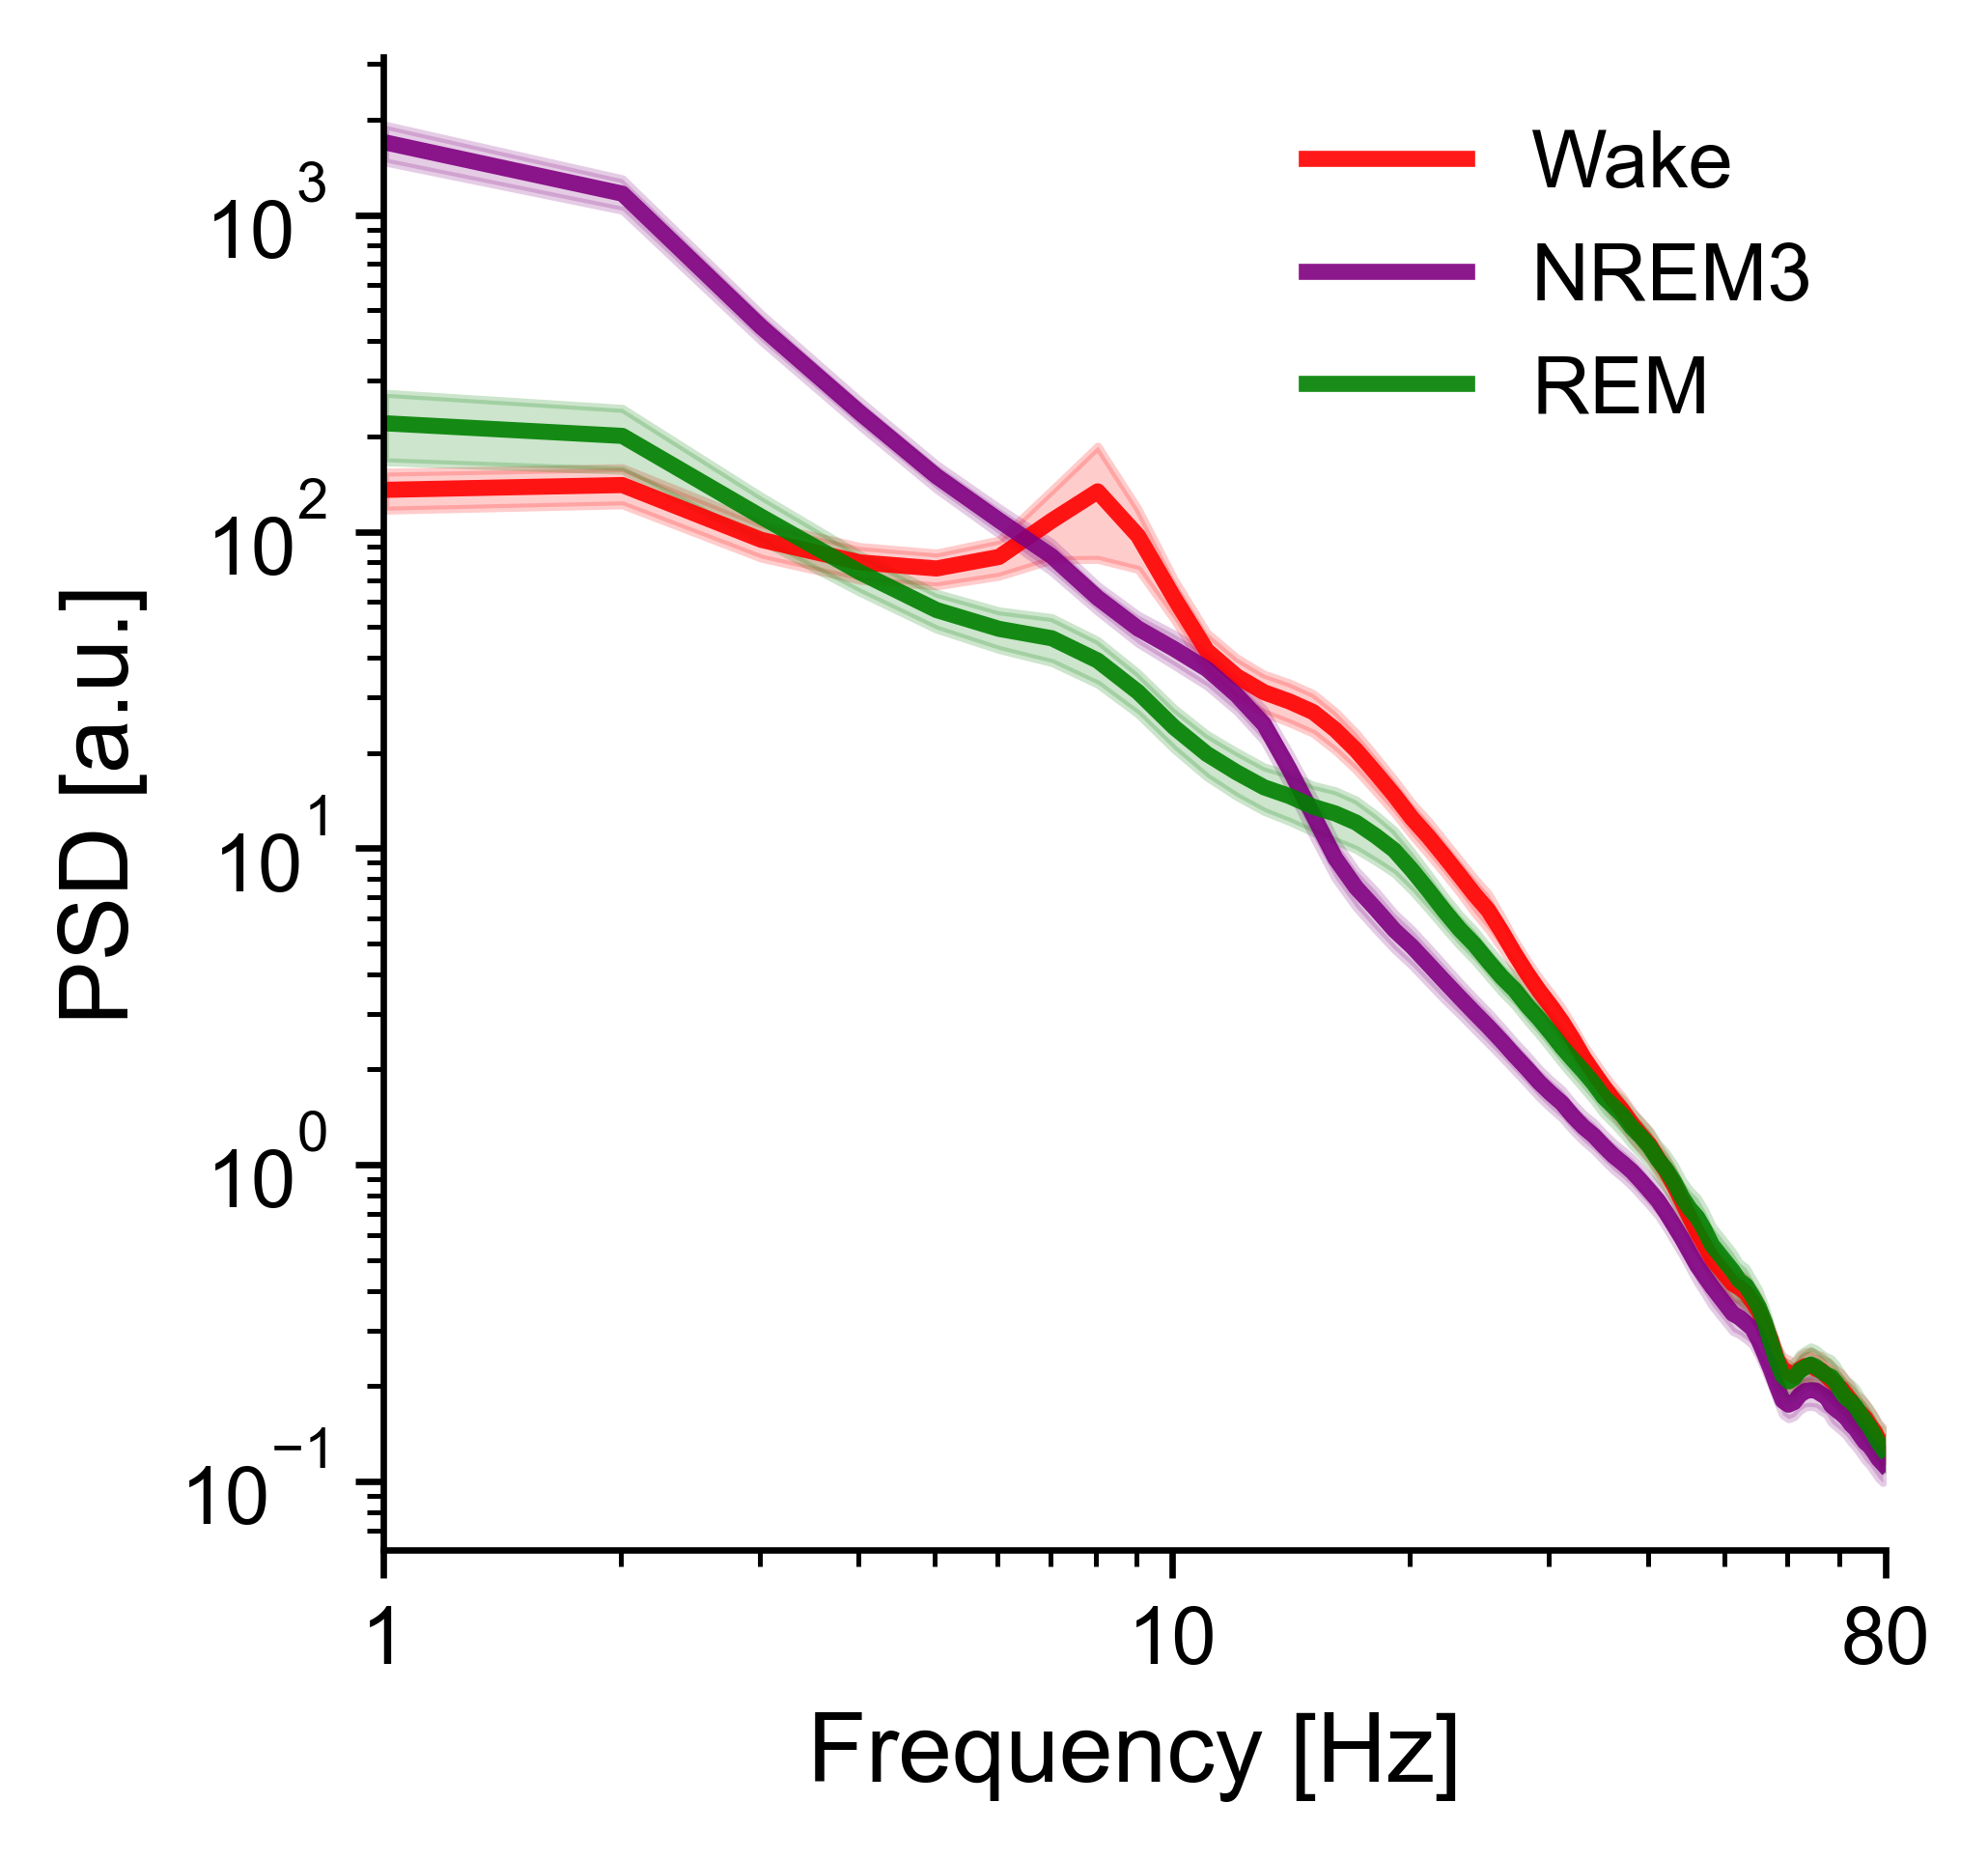

In [22]:
stages_dict = {"W": "Wake", "N3": "NREM3", "R": "REM"}

# Set up the figure
fig, ax = plt.subplots(figsize=_get_figsize_inches((8.5, 8.5)), dpi=600)

# Find patients subfolders
pats = [pat.stem for pat in tau_path.glob("*") if pat.is_dir()]

# Loop through stages
for stage in ["W", "N3", "R"]:

    # Store ACF for all patients
    psd_pats_stage = []
    freqs = None

    # Loop through patients
    for pat in pats:
        pat_dir = tau_path.joinpath(pat)
        # Load ACF
        try:
            with open(
                pat_dir.joinpath("PSD/" + pat + "_" + stage.lower() + ".pkl"),
                "rb",
            ) as f:
                psd_pat_stage = pickle.load(f)
        except FileNotFoundError:
            continue

        # Append channels
        psd_pats_stage.append(psd_pat_stage["psd"].mean(axis=0).mean(axis=0))
        if freqs is None:
            freqs = psd_pat_stage["freqs"]

    # Average across patients
    N_pats = len(psd_pats_stage)
    psd_pats_stage = np.stack(psd_pats_stage)
    psd_stage_avg = psd_pats_stage.mean(axis=0)
    psd_stage_se = psd_pats_stage.std(axis=0) / np.sqrt(N_pats)

    # Figure ACF
    ax.plot(
        freqs,
        psd_stage_avg,
        c=color_stages[stage],
        label=stages_dict[stage],
        lw=2,
        alpha=0.9,
    )
    ax.fill_between(
        freqs,
        psd_stage_avg - psd_stage_se,
        psd_stage_avg + psd_stage_se,
        color=color_stages[stage],
        alpha=0.2,
    )
# Plot parameters
ax.set_xscale("log")
ax.set_xlim(1, 80)
ax.set_xticks([1, 10, 80], labels=[1, 10, 80], fontsize=fsize.TICK_SIZE)
ax.set_yscale("log")
ax.set_xlabel("Frequency [Hz]", fontsize=fsize.LABEL_SIZE)
# ax.set_ylim(-0.4, 1)
# ax.set_yticks([-0.4, 0, 0.5, 1], labels=[-0.4, 0, 0.5, 1], fontsize=fsize.TICK_SIZE)
ax.set_ylabel("PSD [a.u.]", fontsize=fsize.LABEL_SIZE)
ax.spines[["top", "right"]].set_visible(False)
ax.legend(frameon=False, fontsize=fsize.TICK_SIZE, loc="upper right")

# Save figure
save_figure(fig, fig_path.joinpath("Fig_xx", f"FigX_PSD_average.svg"))

plt.show()

### E) Correlation with structure as bar plot (do not use)

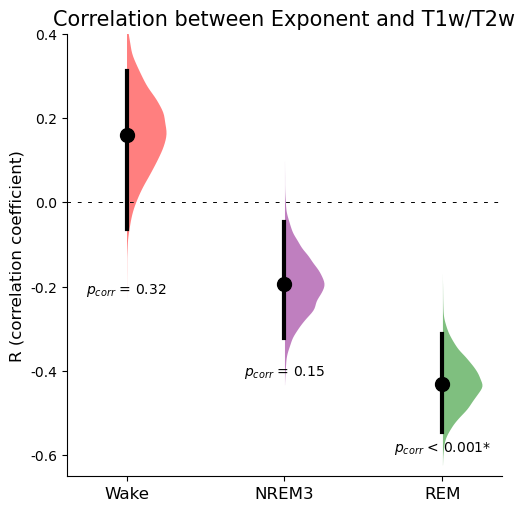

In [29]:
fig, ax = plt.subplots(figsize=(5, 5), layout="constrained")

for i, stage in enumerate(["W", "N3", "R"]):

    p_str = r"$p_{corr}$ "
    p_str += f"= {p_corrs[stage]:.2f}" if p_corrs[stage] > 0.001 else "< 0.001"
    p_str += "*" if p_corrs[stage] < 0.05 else ""
    half_violin_plot(
        ax,
        rhos[stage],
        x_pos=i,
        ci=list(rhos_boot[stage].confidence_interval),
        y_boot=rhos_boot[stage].bootstrap_distribution,
        color=color_stages[stage],
        pval=p_str,
    )

ax.set_xticks([0, 1, 2], labels=["Wake", "NREM3", "REM"], fontsize=12)
ax.set_ylim(-0.65, 0.4)
ax.set_yticks(
    [-0.6, -0.4, -0.2, 0.0, 0.2, 0.4], labels=[-0.6, -0.4, -0.2, 0.0, 0.2, 0.4], fontsize=10
)
ax.set_ylabel("R (correlation coefficient)", fontsize=12)
ax.set_title("Correlation between Exponent and T1w/T2w", fontsize=15)
ax.spines[["top", "right"]].set_visible(False)

fig.savefig(
    fig_path.joinpath("Fig_2", "Fig2_exp_corr_struct_violin.svg"),
    format="svg",
    bbox_inches="tight"
)

plt.show()